# Chapter 2: Up and Running with Tensorflow
-----
-----

- Define a graph of computation(python) -(API)> efficient C++ code.
- It is possible to break graph into chuncks and run them in parallel.
- It runs pretty much anywhere with tenforflowlite and js


In [41]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [2]:
import tensorflow as tf
print(tf.__version__)

1.10.1


## Creating Your First Graph and Running It in a Session
-----

In [9]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y+y+2

The above code does not preform the computation, it create a computation graph.

To evaluate the graph we need to use tf _session_ and use it to initialize variables and evalute f.

In [5]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)

42


In [6]:
sess.close()

In [11]:
# better way
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

result

42

Notes:
- makes code easier to read
- session automatically closed at the end of block

In [12]:
# initialize all variable at once, creates a node in the graph that will initialize the session
init = tf.global_variables_initializer() # prepare an init node

with tf.Session() as sess:
    init.run()
    result = f.eval()
    
result

42

In [13]:
# in jupyter notebook might be preferable to create an `InteractiveSession`

sess = tf.InteractiveSession()
init.run()
result = f.eval()
print(result)
sess.close()

42


Tensorflow program is typically split into two parts:
1. build computation graph (construction phase), respresents ML model and the computations required to train it.
2. runs the graph (execution phase), generally runs a loop that evaluates a training step repeatedly, gradually imporving the models parameters.

## Managing Graphs
-----

Any node you create is added to the grpah

In [14]:
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [15]:
# some you want multiple independent graphs

graph = tf.Graph()

with graph.as_default():
    x2 = tf.Variable(2)
    
print(x2.graph is graph)
print(x2.graph is tf.get_default_graph())

True
False


In jupyter notebook running same command is common, so the graphs ends up having duplicate nodes. Clean the graph using

> tf.reset_default_graph()

## Lifecycle of a Node Value
-----


In [16]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print(y.eval()) # evaluation order w -> x -> y
    print(z.eval()) # evaluation order w -> x -> y, note that w and x are re-evaluated

10
15


In [17]:
with tf.Session() as sess:
    y_val, z_val = sess.run([y,z]) # evaluation order w -> x -> y, note that w and x are only evaluated once ande used for both computations
    print(y_val)
    print(z_val)

10
15


## Linear Regression with Tensorflow
-----


In [42]:
import numpy as np
from sklearn.datasets import fetch_california_housing
reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()

theta_value

array([[-3.7113808e+01],
       [ 4.3607268e-01],
       [ 9.4055878e-03],
       [-1.0649091e-01],
       [ 6.4165664e-01],
       [-4.0657296e-06],
       [-3.7811301e-03],
       [-4.2320788e-01],
       [-4.3653172e-01]], dtype=float32)

## Implementing Gradient Descent
-----

remember to normalize features

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m,1)), scaled_housing_data]

#### Manually Computing the Gradients

In [44]:
reset_graph()


n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
best_theta

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.71450067
Epoch 200 MSE = 0.5667049
Epoch 300 MSE = 0.5555719


Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.53650916


Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474


array([[ 2.0685523 ],
       [ 0.8874027 ],
       [ 0.14401656],
       [-0.34770885],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145283],
       [-0.6375278 ]], dtype=float32)

#### Using Autodiff

In [46]:
reset_graph()


n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
#######################################
# replace with autodiff
gradients = tf.gradients(mse, [theta])[0]
#######################################
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
best_theta

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705


Epoch 300 MSE = 0.5555719
Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294


Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474


array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

#### Using an Optimizer

Tensorflow compute the gradient, but also provides optimizers (gradient descent optimizer)

In [47]:
reset_graph()


n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
#######################################
# replace with optimizer


optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

#######################################
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()
best_theta

Epoch 0 MSE = 9.161543
Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.5555719


Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362
Epoch 600 MSE = 0.5396294
Epoch 700 MSE = 0.5365092


Epoch 800 MSE = 0.5340678
Epoch 900 MSE = 0.5321474


array([[ 2.0685525 ],
       [ 0.8874027 ],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.6614528 ],
       [-0.6375277 ]], dtype=float32)

## Feeding Data to the Training Algorithm
-----


In [29]:
A = tf.placeholder(tf.float32, shape=(None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval(feed_dict={A: [[1, 2, 3]]})
    B_val_2 = B.eval(feed_dict={A: [[4, 5, 6], [7, 8, 9]]})

print(B_val_1)
print(B_val_2)

[[6. 7. 8.]]
[[ 9. 10. 11.]
 [12. 13. 14.]]


In [48]:
# mini-batch gradient decent

reset_graph()


n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()


batch_size = 100
n_batches = int(np.ceil(m / batch_size))

def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = scaled_housing_data_plus_bias[indices]
    y_batch = housing.target.reshape(-1, 1)[indices] 
    return X_batch, y_batch


with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()
    
best_theta

array([[ 2.0714476 ],
       [ 0.8462012 ],
       [ 0.11558535],
       [-0.26835832],
       [ 0.32982782],
       [ 0.00608358],
       [ 0.07052915],
       [-0.87988573],
       [-0.8634251 ]], dtype=float32)

## Saving and Restoring Models
-----

Once trained you can save a model. Just create a saver node at the end of construction phase.


In [50]:
reset_graph()

n_epochs = 1000                                                                      
learning_rate = 0.01                                                                  

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      
error = y_pred - y                                                                    
mse = tf.reduce_mean(tf.square(error), name="mse")                                    
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)            
training_op = optimizer.minimize(mse)                                                 

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                                
            save_path = saver.save(sess, "tmp_models/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    save_path = saver.save(sess, "tmp_models/my_model_final.ckpt")

Epoch 0 MSE = 9.161543


Epoch 100 MSE = 0.7145006
Epoch 200 MSE = 0.566705


Epoch 300 MSE = 0.5555719


Epoch 400 MSE = 0.5488112
Epoch 500 MSE = 0.5436362


Epoch 600 MSE = 0.5396294


Epoch 700 MSE = 0.5365092
Epoch 800 MSE = 0.5340678


Epoch 900 MSE = 0.5321474


In [33]:
# restore model

with tf.Session() as sess:
    saver.restore(sess, "tmp_models/my_model_final.ckpt")
    best_theta_restored = theta.eval()

INFO:tensorflow:Restoring parameters from tmp_models/my_model_final.ckpt


In [34]:
np.allclose(best_theta, best_theta_restored)

True

## Visualizing the Graph and Training Curves Using Tensorboard
-----

In [63]:
reset_graph()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)



In [64]:
n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [65]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [66]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

In [67]:
with tf.Session() as sess:                                                        
    sess.run(init)                                                                

    for epoch in range(n_epochs):                                                 
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

In [68]:
file_writer.close()

go to the log directory with a shell

- `ls -l tf_logs/run*` : list contents of the log directory
- activate your virtual env
- `tensorboard --logdir tf_logs/`

## Name Scopes
-----

Graphs with a lot of nodes can become cluttered, so you can create a name scope to group related nodes.

In [69]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")

In [70]:
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")

In [71]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [72]:
n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

file_writer.flush()
file_writer.close()
print("Best theta:")
print(best_theta)

Best theta:
[[ 2.0703337 ]
 [ 0.8637145 ]
 [ 0.12255151]
 [-0.31211874]
 [ 0.38510373]
 [ 0.00434168]
 [-0.01232954]
 [-0.83376896]
 [-0.8030471 ]]


## Modularity
-----

Adding RelU

In [73]:
reset_graph()

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")

w1 = tf.Variable(tf.random_normal((n_features, 1)), name="weights1")
w2 = tf.Variable(tf.random_normal((n_features, 1)), name="weights2")
b1 = tf.Variable(0.0, name="bias1")
b2 = tf.Variable(0.0, name="bias2")

z1 = tf.add(tf.matmul(X, w1), b1, name="z1")
z2 = tf.add(tf.matmul(X, w2), b2, name="z2")

relu1 = tf.maximum(z1, 0., name="relu1")
relu2 = tf.maximum(z1, 0., name="relu2")  # Oops, cut&paste error! Did you spot it?

output = tf.add(relu1, relu2, name="output")

Hard to maintain and error prone, and if you wanted more ReLU. Tensoflow let you stay DRY (Don't repeat yourself).

Create a function to build ReLU.

In [75]:
def relu(X):
    w_shape = (int(X.get_shape()[1]),1)
    w = tf.Variable(tf.random_normal(w_shape), name="weights")
    b = tf.Variable(0.0, name="bias")
    z = tf.add(tf.matmul(X,w), b, name="z")
    return tf.maximum(z, 0., name="relu")

n_features = 3
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X) for i in range(5)]
output = tf.add_n(relus, name="output")

In [76]:
file_writer = tf.summary.FileWriter("logs/relu1", tf.get_default_graph())

Can use scopes to make graph look cleaner

## Sharing Variables
-----

Simple solution: create variable and pass it as a parameter to the functions that need it 

In [79]:
reset_graph()

def relu(X, threshold):
    with tf.name_scope("relu"):
        w_shape = (int(X.get_shape()[1]), 1)                        
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  
        b = tf.Variable(0.0, name="bias")                           
        z = tf.add(tf.matmul(X, w), b, name="z")                    
        return tf.maximum(z, threshold, name="max")

threshold = tf.Variable(0.0, name="threshold")
X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = [relu(X, threshold) for i in range(5)]
output = tf.add_n(relus, name="output")

If there are many variables this can be painful:
- create python dictionary
- class for each module
- sharing variable as an attribute of the function 

In [80]:


reset_graph()

def relu(X):
    with tf.name_scope("relu"):
        # sharing variable as an attribute of the function
        if not hasattr(relu, "threshold"):
            relu.threshold = tf.Variable(0.0, name="threshold")
        w_shape = int(X.get_shape()[1]), 1                          
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  
        b = tf.Variable(0.0, name="bias")                           
        z = tf.add(tf.matmul(X, w), b, name="z")                    
        return tf.maximum(z, relu.threshold, name="max")



Tensorflows solution, which may lead to slightly cleaner and more modular code:
- idea is to use the `get_variable()` function 

In [81]:
reset_graph()

with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))

This code will fetch the exisitng "relu/threshold" variable, or raise an exception if it does not exist or if it was not created using get_variable

You can set the reuse attribute to true inside the block

In [82]:
with tf.variable_scope("relu", reuse=True):
    threshold = tf.get_variable("threshold")

In [83]:
with tf.variable_scope("relu") as scope:
    scope.reuse_variables()
    threshold = tf.get_variable("threshold")

In [84]:
reset_graph()

def relu(X):
    with tf.variable_scope("relu", reuse=True):
        threshold = tf.get_variable("threshold")
        w_shape = int(X.get_shape()[1]), 1                          # not shown
        w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
        b = tf.Variable(0.0, name="bias")                           # not shown
        z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
        return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
with tf.variable_scope("relu"):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
relus = [relu(X) for relu_index in range(5)]
output = tf.add_n(relus, name="output")

defines the function, creates the relu/threshold varaible, and builds five relu by calling relu() function. The function reuses the relu/threshold variable.

In [85]:
file_writer = tf.summary.FileWriter("logs/relu6", tf.get_default_graph())
file_writer.close()

Unfortunate that the threshold variable exists outside of the relu() function, but there is a fix to thay

In [86]:
reset_graph()

def relu(X):
    threshold = tf.get_variable("threshold", shape=(),
                                initializer=tf.constant_initializer(0.0))
    w_shape = (int(X.get_shape()[1]), 1)                        # not shown in the book
    w = tf.Variable(tf.random_normal(w_shape), name="weights")  # not shown
    b = tf.Variable(0.0, name="bias")                           # not shown
    z = tf.add(tf.matmul(X, w), b, name="z")                    # not shown
    return tf.maximum(z, threshold, name="max")

X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
relus = []
for relu_index in range(5):
    with tf.variable_scope("relu", reuse=(relu_index >= 1)) as scope:
        relus.append(relu(X))
output = tf.add_n(relus, name="output")

In [87]:
file_writer = tf.summary.FileWriter("logs/relu9", tf.get_default_graph())
file_writer.close()

## Exercises
-----

1. 
Benefits:
	- Auto gradient computation
	- Easier to run the computation in parallel or over several devices
Drawbacks:
	- Step learning curve
	- hard to debbug
2. yes
3. no, because the graph is run and computed twice in the first code snippet, while the second will only compute the graph once. If any of those operation have side effect then the result might different.
4. no, graphs must be merged
5. Each session has its own copy
6. initialized when it's initilizer is called and destroyed when the session is closed 
7. a variable has initial value, before it can be run it must be initialized, and running it returns that value. A placeholder hold information about the type and shape of the tensor, they have no value.
8. An exception will be raised if the operation depends on it, otherwise no exception will be raised.
9. You can feed the output value of any operation.
10. 
	- Construction phase: create variable -> create placeholder for assignment value -> create assignment node using tf.assign(x, x_placeholder)
	- Evaluation phase: initializer and run -> evaluate -> assign new value -> evaluate
11. reverse-mode : n_outputs + 1, so in this case it would traverse the graph twice. forward_mode: n_inputs: in this case it would traverse the graph 10 times. Symbolic Diff: creates a new graph
12. 

In [88]:
from sklearn.datasets import make_moons
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
m = 1000
X_moons, y_moons = make_moons(m, noise=0.1, random_state=42)

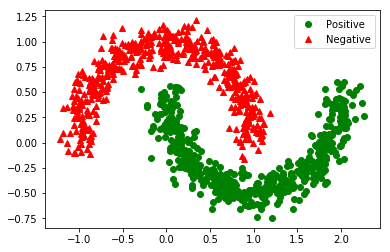

In [89]:
plt.plot(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1], 'go', label="Positive")
plt.plot(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [91]:
X_moons_with_bias = np.c_[np.ones((m, 1)), X_moons]
y_moons_column_vector = y_moons.reshape(-1, 1)
test_ratio = 0.2
test_size = int(m * test_ratio)
X_train = X_moons_with_bias[:-test_size]
X_test = X_moons_with_bias[-test_size:]
y_train = y_moons_column_vector[:-test_size]
y_test = y_moons_column_vector[-test_size:]

def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

X_batch, y_batch = random_batch(X_train, y_train, 5)

In [92]:
reset_graph()

In [93]:
n_inputs = 2

In [94]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n_inputs + 1, 1], -1.0, 1.0, seed=42), name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = tf.sigmoid(logits)
loss = tf.losses.log_loss(y, y_proba)

In [95]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

In [97]:
init = tf.global_variables_initializer()

In [98]:
n_epochs = 1000
batch_size = 50
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val = loss.eval({X: X_test, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)

    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})

Epoch: 0 	Loss: 0.79260236


Epoch: 100 	Loss: 0.3434635


Epoch: 200 	Loss: 0.30754045


Epoch: 300 	Loss: 0.29288894


Epoch: 400 	Loss: 0.28533572


Epoch: 500 	Loss: 0.28047806


Epoch: 600 	Loss: 0.27808294


Epoch: 700 	Loss: 0.2761544


Epoch: 800 	Loss: 0.27551997


Epoch: 900 	Loss: 0.27491233


In [100]:
from sklearn.metrics import precision_score, recall_score
y_pred = (y_proba_val >= 0.5)
y_pred[:5]
precision_score(y_test, y_pred)

0.8627450980392157

In [101]:
recall_score(y_test, y_pred)

0.8888888888888888

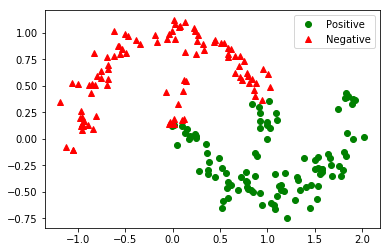

In [102]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

its a linear classifier so it pretty much as good as that gets, but we can add features crosses